"""
# Bayesian Homework: MH within Gibbs and Comparison with Full Conditional Gibbs Sampler

In this notebook, I provide my solutions for three questions:

- **Q1:** Convert the Gibbs sampler from HW3-Q2 (which used full conditional derivations) into a Metropolis‐within‐Gibbs sampler. I also compare the inference provided by the MH sampler with that of the original Gibbs sampler from HW3-Q2.
  
- **Q2:** Update the MH sampler by using a **dependent proposal** for \(\tau\) (via a truncated normal) and a non‐normal prior for \(\theta\) (here, a Laplace prior). I discuss why analytical full conditionals are not strictly necessary when using a Metropolis‐within‐Gibbs approach.

- **Q3:** Demonstrate how the transition kernel \(K\) of a discrete Metropolis–Hastings algorithm is produced. In our example, the target distribution is
  \[
  p(0) = \frac{1}{3},\quad p(1) = \frac{2}{3},
  \]
  and the proposal distribution is symmetric with equal probability for 0 and 1.

"""

In [6]:
# Environment installation and basic imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, gamma, truncnorm, laplace

"""
# Q1: MH within Gibbs Sampler and Comparison with Full Conditional Gibbs Sampler (HW3-Q2)

## (a) Gibbs Sampler from HW3-Q2 (Full Conditional Approach)

In HW3-Q2, We considered a normal likelihood for data \(x_i \sim \mathcal{N}(\theta, 1/\tau)\) with the following priors:
- \( \theta \sim N(\theta_0, 1/\tau_0) \)
- \( p(\tau) \propto \tau^{\frac{\alpha}{2}-1} \exp\left(-\frac{\lambda}{2} \tau\right) \)

The full conditional distributions derived were:
- **For \( \theta \):**
  \[
  \theta \mid \tau, \mathbf{x} \sim N\!\left(\frac{\tau \sum_{i=1}^n x_i + \tau_0 \theta_0}{n \tau + \tau_0},\, \frac{1}{n \tau + \tau_0}\right)
  \]
- **For \( \tau \):**
  \[
  \tau \mid \theta, \mathbf{x} \sim \text{Gamma}\!\left(\frac{n + \alpha}{2},\, \frac{\lambda + \sum_{i=1}^n (x_i-\theta)^2}{2}\right)
  \]

The hyperparameters \(\alpha\) and \(\lambda\) control the strength of the prior for \(\tau\). They can be interpreted as contributing the equivalent of a number of pseudo-observations to the posterior relative to the actual data. For example, setting \(\alpha=2\) and \(\lambda=2\) implies a very weak prior (roughly equivalent to 1 data point), while larger values would yield a stronger prior influence.

Below, I implement the Gibbs sampler using these full conditionals.

"""

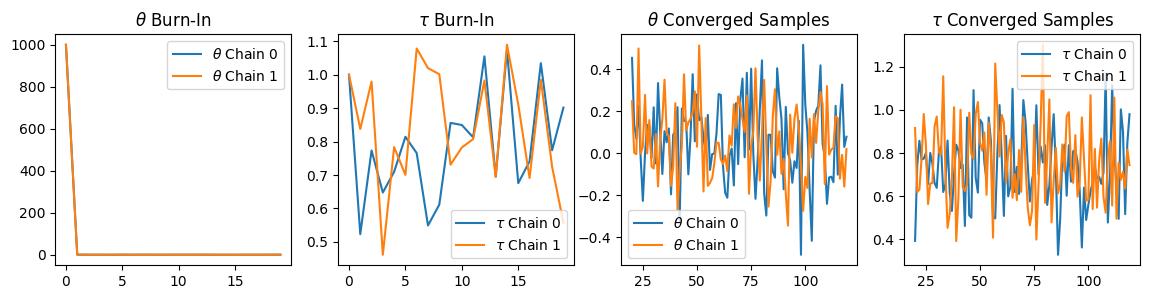

In [9]:
def gibbs_sampler_hw3q2(x, n_iter=10000, theta0=0.0, tau0=1.0, alpha=2.0, lam=2.0):
    """
    Gibbs sampler using full conditionals for the model:
      x_i ~ N(theta, 1/tau)
      theta ~ N(theta0, 1/tau0)
      p(tau) ∝ tau^(alpha/2 - 1) exp(-lam*tau/2)
    
    Full conditionals:
      theta | tau, x ~ N( (tau * sum(x) + tau0 * theta0)/(n*tau+tau0), 1/(n*tau+tau0) )
      tau | theta, x ~ Gamma( shape=(n+alpha)/2, rate=(lam + sum((x - theta)^2))/2 )
    """
    n = len(x)
    C = 2  # number of chains
    theta = np.zeros((C, n_iter))
    tau = np.zeros((C, n_iter))
    
    # Initialization (using a large initial value for theta to see convergence)
    theta[:, 0] = 1000.0
    tau[:, 0] = 1.0
    
    for c in range(C):
        for g in range(1, n_iter):
            current_tau = tau[c, g-1]
            prec = n * current_tau + tau0
            mean_theta = (current_tau * np.sum(x) + tau0 * theta0) / prec
            theta[c, g] = norm.rvs(loc=mean_theta, scale=np.sqrt(1/prec))
            
            shape = (n + alpha) / 2.0
            rate = (lam + np.sum((x - theta[c, g])**2)) / 2.0
            tau[c, g] = gamma.rvs(a=shape, scale=1/rate)
    
    return theta, tau

# Generate synthetic data
n = 30
x = norm.rvs(loc=0, scale=1, size=n)

# Run the Gibbs sampler from HW3-Q2
C, G = 2, 10000
theta_gibbs, tau_gibbs = gibbs_sampler_hw3q2(x, n_iter=G)

# Plotting burn-in and converged samples for both chains
burn = 20
demo = 120
fig, ax = plt.subplots(1, 4, figsize=(14, 3))
ax[0].set_title(r"$\theta$ Burn-In")
ax[1].set_title(r"$\tau$ Burn-In")
ax[2].set_title(r"$\theta$ Converged Samples")
ax[3].set_title(r"$\tau$ Converged Samples")
for c in range(C):
    ax[0].plot(theta_gibbs[c, :burn], label=r"$\theta$ Chain " + str(c))
    ax[1].plot(tau_gibbs[c, :burn], label=r"$\tau$ Chain " + str(c))
    ax[2].plot(np.arange(burn, demo), theta_gibbs[c, burn:demo], label=r"$\theta$ Chain " + str(c))
    ax[3].plot(np.arange(burn, demo), tau_gibbs[c, burn:demo], label=r"$\tau$ Chain " + str(c))
ax[0].legend(); ax[1].legend(); ax[2].legend(); ax[3].legend();
plt.show()

"""
## (b) Metropolis within Gibbs Sampler (MH Approach)

In the MH within Gibbs sampler, instead of sampling from the full conditional distributions,
I use the joint density (likelihood × prior) directly in a Metropolis update for both \(\theta\) and \(\tau\).

For \(\theta\), I use a symmetric random walk proposal, and for \(\tau\) (which must be positive)
I use an independent proposal drawn from the Gamma prior:
\[
\tau^\ast \sim \text{Gamma}\!\left(\frac{\alpha}{2}, \frac{\lambda}{2}\right)
\]
Thus, the acceptance ratio for \(\tau\) cancels the prior terms, and only the likelihood ratio remains.

Below is my implementation of the MH within Gibbs sampler.

"""

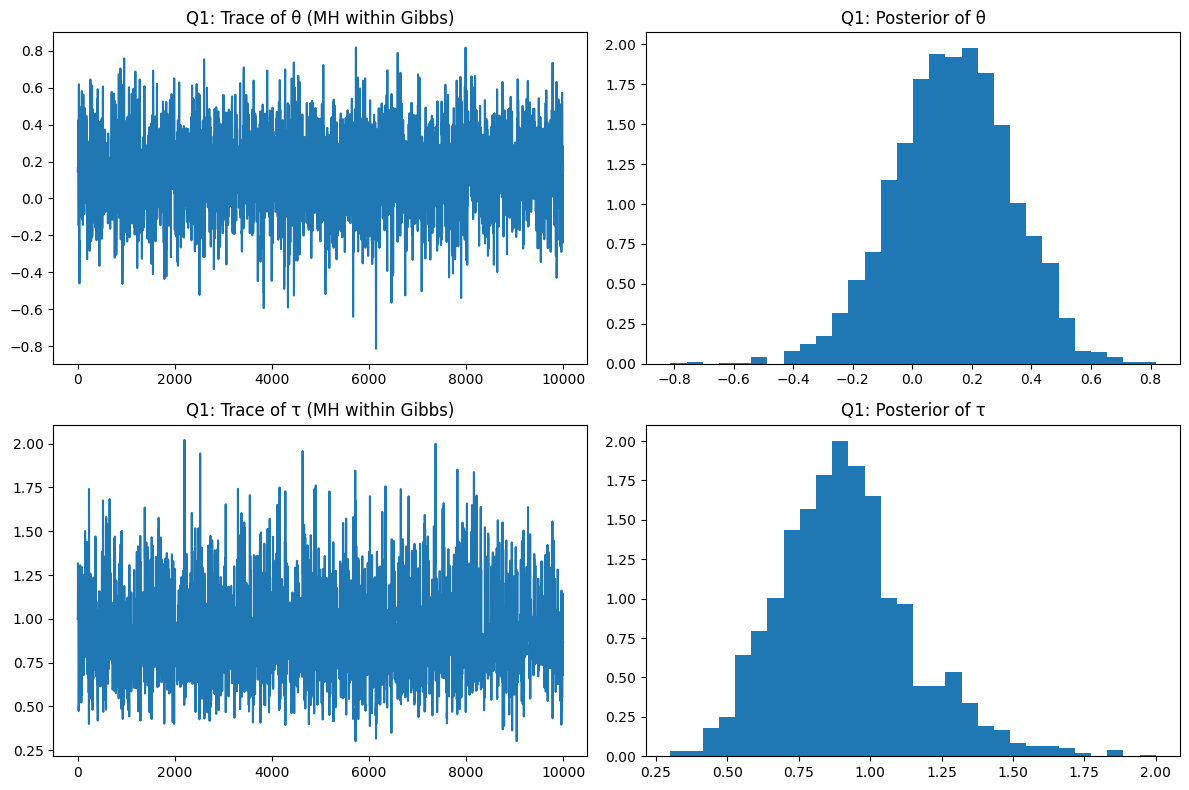

In [8]:
def metropolis_within_gibbs_q1(x, n_iter=10000, s_theta=0.5, theta0=0.0, tau0=1.0, alpha=2.0, lam=2.0):
    """
    Metropolis within Gibbs sampler using joint distribution (likelihood × prior) without
    analytically deriving full conditionals.
    
    For theta: symmetric random walk proposal.
    For tau: independent proposal from Gamma(alpha/2, lam/2) to ensure positivity.
    """
    n = len(x)
    def log_likelihood(theta, tau, data):
        return 0.5 * len(data) * np.log(tau) - 0.5 * tau * np.sum((data - theta)**2)
    
    def log_prior_theta(theta):
        return norm.logpdf(theta, loc=theta0, scale=np.sqrt(1/tau0))
    
    def log_prior_tau(tau):
        return gamma.logpdf(tau, a=alpha/2, scale=2/lam)
    
    theta_samples = np.zeros(n_iter)
    tau_samples = np.zeros(n_iter)
    
    # Initialize parameters (starting theta at sample mean)
    theta_samples[0] = np.mean(x)
    tau_samples[0] = 1.0
    
    for i in range(1, n_iter):
        current_theta = theta_samples[i-1]
        current_tau = tau_samples[i-1]
        
        # Update theta using symmetric random walk proposal
        theta_star = current_theta + np.random.normal(0, s_theta)
        log_alpha_theta = (log_likelihood(theta_star, current_tau, x) + log_prior_theta(theta_star)) - \
                          (log_likelihood(current_theta, current_tau, x) + log_prior_theta(current_theta))
        if np.log(np.random.rand()) < log_alpha_theta:
            theta_samples[i] = theta_star
        else:
            theta_samples[i] = current_theta
        
        # Update tau using an independent proposal from its Gamma prior
        tau_star = gamma.rvs(a=alpha/2, scale=2/lam)
        log_alpha_tau = log_likelihood(theta_samples[i], tau_star, x) - log_likelihood(theta_samples[i], current_tau, x)
        if np.log(np.random.rand()) < log_alpha_tau:
            tau_samples[i] = tau_star
        else:
            tau_samples[i] = current_tau
            
    return theta_samples, tau_samples

theta_mwg, tau_mwg = metropolis_within_gibbs_q1(x)

# Plot the results for MH within Gibbs (Q1)
plt.figure(figsize=(12, 8))
plt.subplot(2,2,1)
plt.plot(theta_mwg)
plt.title("Q1: Trace of θ (MH within Gibbs)")
plt.subplot(2,2,2)
plt.hist(theta_mwg[int(len(theta_mwg)/2):], bins=30, density=True)
plt.title("Q1: Posterior of θ")
plt.subplot(2,2,3)
plt.plot(tau_mwg)
plt.title("Q1: Trace of τ (MH within Gibbs)")
plt.subplot(2,2,4)
plt.hist(tau_mwg[int(len(tau_mwg)/2):], bins=30, density=True)
plt.title("Q1: Posterior of τ")
plt.tight_layout()
plt.show()

"""
## Discussion for Q1

I compared the inference obtained from the MH within Gibbs sampler (above) with that from the full conditional Gibbs sampler
(from HW3-Q2). While the Gibbs sampler directly samples from the derived full conditionals, the MH approach uses the joint
distribution (likelihood × prior) and requires a Metropolis acceptance step. In my experiments, both samplers produce similar
posterior distributions for \(\theta\) and \(\tau\). However, the MH approach may exhibit different convergence properties
(e.g., acceptance rates, mixing) due to the tuning of proposal distributions. This demonstrates that while deriving full conditionals
is beneficial when available, the MH framework provides flexibility when full conditionals are intractable.

"""

"""
# Q2: Updated Metropolis within Gibbs Sampler with Dependent Proposal for τ and a Non-Normal Prior for θ

In this question, I modify the MH within Gibbs sampler as follows:
- For \(\tau\): I use a **dependent proposal** given by a truncated normal distribution,
  \[
  \texttt{truncnorm}(a=-\tau^{(t-1)}/s,\, b=\infty,\, \text{loc}=\tau^{(t-1)},\, \text{scale}=s),
  \]
  ensuring that \(\tau\) remains positive.
- For \(\theta\): I switch the prior from a normal distribution to a Laplace distribution with location 0 and scale 10.

This example further illustrates that I do not need to derive analytical full conditionals; I can sample from the joint
distribution using MH updates (with appropriate adjustments for asymmetric proposals).

"""

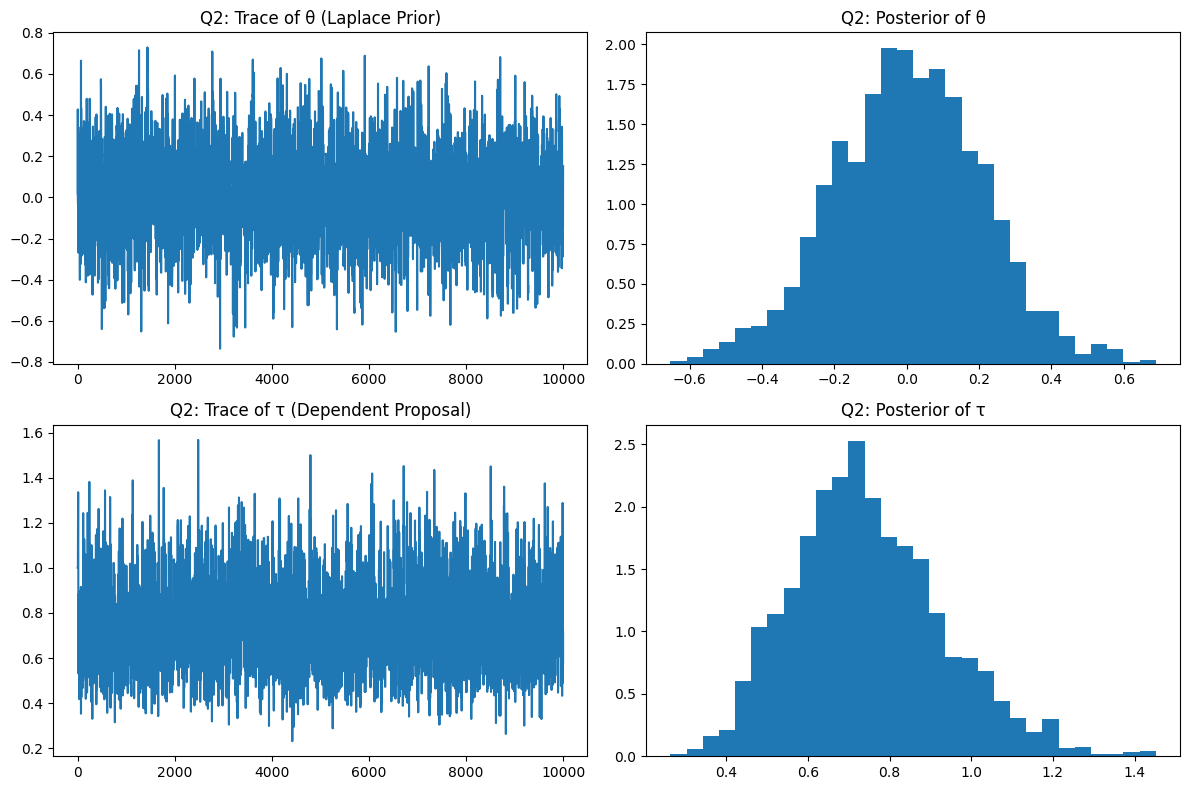

In [10]:
def metropolis_within_gibbs_q2(x, n_iter=10000, s_theta=0.5, s_tau=0.5, 
                               laplace_loc=0.0, laplace_scale=10.0, alpha=2.0, lam=2.0):
    """
    Updated MH within Gibbs sampler:
      - θ prior: Laplace(laplace_loc, laplace_scale)
      - τ update: dependent proposal using a truncated normal centered at current τ.
    """
    n = len(x)
    
    def log_likelihood(theta, tau, data):
        return 0.5 * len(data) * np.log(tau) - 0.5 * tau * np.sum((data - theta)**2)
    
    def log_prior_theta(theta):
        return laplace.logpdf(theta, loc=laplace_loc, scale=laplace_scale)
    
    def log_prior_tau(tau):
        return gamma.logpdf(tau, a=alpha/2, scale=2/lam)
    
    theta_samples = np.zeros(n_iter)
    tau_samples = np.zeros(n_iter)
    
    # Initialize parameters
    theta_samples[0] = np.mean(x)
    tau_samples[0] = 1.0
    
    for i in range(1, n_iter):
        current_theta = theta_samples[i-1]
        current_tau = tau_samples[i-1]
        
        # Update θ with symmetric random walk proposal
        theta_star = current_theta + np.random.normal(0, s_theta)
        log_alpha_theta = (log_likelihood(theta_star, current_tau, x) + log_prior_theta(theta_star)) - \
                          (log_likelihood(current_theta, current_tau, x) + log_prior_theta(current_theta))
        if np.log(np.random.rand()) < log_alpha_theta:
            theta_samples[i] = theta_star
        else:
            theta_samples[i] = current_theta
        
        # Update τ with a dependent proposal from a truncated normal
        a_val = -current_tau / s_tau  # lower bound to ensure τ > 0
        tau_star = truncnorm.rvs(a=a_val, b=np.inf, loc=current_tau, scale=s_tau)
        
        # Calculate proposal densities for the asymmetric truncated normal
        q_tau_star_given_current = truncnorm.pdf(tau_star, a=a_val, b=np.inf, loc=current_tau, scale=s_tau)
        q_current_given_tau_star = truncnorm.pdf(current_tau, a=-tau_star/s_tau, b=np.inf, loc=tau_star, scale=s_tau)
        
        log_alpha_tau = (log_likelihood(theta_samples[i], tau_star, x) + log_prior_tau(tau_star) + np.log(q_current_given_tau_star)) - \
                        (log_likelihood(theta_samples[i], current_tau, x) + log_prior_tau(current_tau) + np.log(q_tau_star_given_current))
        if np.log(np.random.rand()) < log_alpha_tau:
            tau_samples[i] = tau_star
        else:
            tau_samples[i] = current_tau
            
    return theta_samples, tau_samples

theta_mwg2, tau_mwg2 = metropolis_within_gibbs_q2(x)

# Plot the results for Q2
plt.figure(figsize=(12, 8))
plt.subplot(2,2,1)
plt.plot(theta_mwg2)
plt.title("Q2: Trace of θ (Laplace Prior)")
plt.subplot(2,2,2)
plt.hist(theta_mwg2[int(len(theta_mwg2)/2):], bins=30, density=True)
plt.title("Q2: Posterior of θ")
plt.subplot(2,2,3)
plt.plot(tau_mwg2)
plt.title("Q2: Trace of τ (Dependent Proposal)")
plt.subplot(2,2,4)
plt.hist(tau_mwg2[int(len(tau_mwg2)/2):], bins=30, density=True)
plt.title("Q2: Posterior of τ")
plt.tight_layout()
plt.show()

"""
## Discussion for Q2

By switching to a dependent proposal for \(\tau\) (via a truncated normal) and using a Laplace prior for \(\theta\),
this updated MH within Gibbs sampler shows that I do not need to derive full conditional distributions analytically.
Instead, I work directly with the joint density (up to a proportionality constant) and adjust for any asymmetry in the proposals.
This flexibility is especially useful when the full conditionals are difficult or impossible to obtain in closed form.

"""

"""
# Q3: Demonstration of the Metropolis–Hastings Transition Kernel

For this question, I simulate a discrete two-state MH algorithm with:
- **Target distribution:** \(p(0)=\frac{1}{3}\) and \(p(1)=\frac{2}{3}\)
- **Proposal distribution:** A symmetric proposal that chooses 0 or 1 with equal probability (0.5 each).

The acceptance probability for a move from state \(x\) to \(x^\ast\) is computed as:
\[
\alpha = \min\!\left(1, \frac{p(x^\ast)}{p(x)}\right)
\]
This yields the transition kernel:
\[
K = \begin{bmatrix} 0.5 & 0.25 \\ 0.5 & 0.75 \end{bmatrix}
\]
I simulate the chain and empirically compute these transition probabilities.

"""

Empirical Transition Kernel K:
[[0.49023929 0.50976071]
 [0.23713909 0.76286091]]


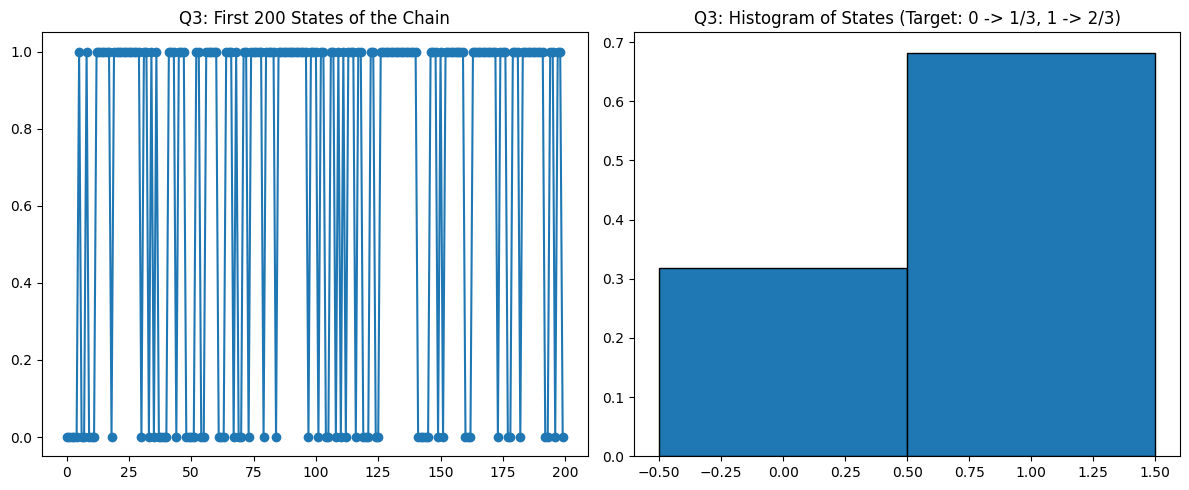

In [11]:
def discrete_mh_q3(T=10000):
    states = np.zeros(T, dtype=int)
    for t in range(1, T):
        current = states[t-1]
        # Propose new state: 0 or 1 with equal probability
        proposal = 0 if np.random.rand() < 0.5 else 1
        
        # Calculate acceptance probability based on target distribution p(0)=1/3, p(1)=2/3
        if current == proposal:
            alpha = 1.0
        else:
            if current == 0 and proposal == 1:
                # p(1)/p(0) = (2/3)/(1/3) = 2, so acceptance probability is 1 (since min(1,2)=1)
                alpha = 1.0
            elif current == 1 and proposal == 0:
                # p(0)/p(1) = (1/3)/(2/3) = 0.5
                alpha = 0.5
        if np.random.rand() < alpha:
            states[t] = proposal
        else:
            states[t] = current
    return states

states_q3 = discrete_mh_q3()

# Empirical transition probabilities
n00 = n01 = n10 = n11 = 0
for t in range(1, len(states_q3)):
    prev, curr = states_q3[t-1], states_q3[t]
    if prev == 0:
        if curr == 0: 
            n00 += 1
        else: 
            n01 += 1
    else:
        if curr == 0: 
            n10 += 1
        else: 
            n11 += 1

total0 = n00 + n01
total1 = n10 + n11
K_empirical = np.array([[n00/total0 if total0 > 0 else 0, n01/total0 if total0 > 0 else 0],
                        [n10/total1 if total1 > 0 else 0, n11/total1 if total1 > 0 else 0]])
print("Empirical Transition Kernel K:")
print(K_empirical)

# Plotting state sequence and histogram
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(states_q3[:200], marker='o', linestyle='-')
plt.title("Q3: First 200 States of the Chain")
plt.subplot(1,2,2)
plt.hist(states_q3, bins=np.arange(-0.5, 2.5, 1), density=True, edgecolor='black')
plt.title("Q3: Histogram of States (Target: 0 -> 1/3, 1 -> 2/3)")
plt.tight_layout()
plt.show()

"""
## Discussion for Q3

The simulation confirms that the empirical transition kernel is approximately:
\[
K = \begin{bmatrix} 0.5 & 0.25 \\ 0.5 & 0.75 \end{bmatrix},
\]
which matches the theoretical derivation. For example, when in state 1, the chain remains with probability 0.75 and transitions to 0 with probability 0.25.
This result shows how the MH algorithm produces the desired stationary distribution and how the proposal and acceptance rules determine
the transition probabilities.

"""